##### Import data

# Project Overview 

This project aims to classify fabric defect using pattern recognition and machine learning techniques. The instances of defects are one of the main challenges fabric manufactors ecnounter on a daily process. By using a camera that captures the sections of fabrics produces and compared it to the corrected shape and pattern, experienced workers in the factory's quality assurance department can identify and categorize which type of farbics defects does it belong to if there is any observable defect. In ths project, we aim to automate the process of classifying the fabric defects with pattern recognition and machine learning algorithms. In ths project report, we will provide our algorithmic solutions for idneityfing fabric defect with Convolutional Neural Network. The decent accuracy could help save a significant amount of time for farbic manufactorures if the technique is incorperated in the fabric's post production qualtiy assurance process.  

Acknowledgment: I have worked with Jack Xu, and Olina Liang on this project. 


# Problem Statement 
The goal is to create an image classifer that identifies the categorcy of defect a image is belonged to. The dataset we are given contains the target images and templet images. Target images are the images that might contain the defects. Templet images are the images that are supposed to correct and free of defects. Each target image has a corresponding template image. And label of such target image tells us the category of error does it belong to and the estimated position and bounding box of the defect. There are a total of 15 defect categories: 

- 0: 'unknown',
- 1: 'escape_printing',
- 2: 'clogging_screen',
- 3: 'broken_hole',
- 4: 'toe_closing_defects',
- 5: 'water_stain',
- 6: 'smudginess',
- 7: 'white_stripe',
- 8: 'hazy_printing',
- 9: 'billet_defects',
- 10: 'trachoma',
- 11: 'color_smear',
- 12: 'crease',
- 13: 'false_positive',
- 14: 'no_alignment'

We are assigned to complete one of the three given tasks. 


In this report we will attempt two tasks: 

## Task 1: 
In task one, we will be working with the full dataset. We will combine category 6 and 12 as one single category. Then we will attempt to classify a total of 9 categories. Note the classification problem is to identify which one of the 9 categories does a image belong to. 

## Task 2：
In task two, we will only be working with a subset of the full data set. We will first take the dataset of categroy 1, 2, 5, and 13. Then we will attempt to classfying a total of 4 categories. The classifcation problem is to identify which one of the 4 categories does an image belong to, knowing the image defect has to belong to one of the 4 categories because the data set only contains the image of 4 categories. 

We wil organize the report by two tasks. 

# Algorithms Overview

For data preprocessing and feature extraction, we simply concategnate the defect areas of the target image and template image. So for the input layer, a usual image will contain only 3 channels, but four input layer contains 6 channels with the first three belonging to the target image and the later three belonging to the template iamge. 

The classifer is a Convolutional Neural Network, which is the best algorithm for image proecessing tasks. The training of CNN requires large amount of training data. We have a decent amount of images for both tasks. For some categories of defect, we don't have enough training image data to be sucessful. So implement some simple data augmentation techniques which we will describe later that helps increase the number of training images. We will use the AlexNet origianlly designed by Alex Krizhevsky. The main characteristics of AlexNet is that it goes pretty deep with eight layers, composed of 5 convolutional layers and 3 fully-connected layers. The filter size decrease from 11 to 5 and then to 3. Our implementation of AlexNet has around 60 million parameters. For the three fully connected layers we will use drop out to prevent the overfitting problem. 

![title](alexnet_diagram.png)

# Task 1: 

# Data Preprocessing
## Importing the data
We will use the following script to read in the labels and data set. We will not include the code here but include at the very end of the report for reference. 

In [39]:
from util_copy import load_fabric_data, extract_label_grouping, extract_label_grouping, load_fabric_images
import numpy as np
from matplotlib import image

Import the dataset by loading the images and label data. 

In [2]:
path = r"C:/Users/Administrator/Desktop/PRML/Project/fabric_data/label_json/**/**.json"

fids, fdata = load_fabric_data(path)
ftype1, ftype2 = extract_label_grouping(fdata)

path = r"C:/Users/Administrator/Desktop/PRML/Project/fabric_data/temp/"
labels, imgs = load_fabric_images(path, fids, fdata, ftype2)

We can take a look at the total number of samples. And we will be working with the entire data set for task 1:

In [3]:
n_samples = len(imgs)
print("Number of samples:", n_samples)

Number of samples: 3371


We are going to resize all of the images to the same size with the following. So that our image data have the same size. This is important because CNN requires the input images to be the same size to be working. 


In [4]:
import cv2
imgs = [cv2.resize(img,(200, 200)) for img in imgs]

## Splitting the data

We will perform two splitting. First time is to splitting the entire data set to training set and testing set. We want to ensure that testing set is completely set aside and not involved in the building of the model at all so that the testing set act as data that the model has never seen before. 

In [5]:
from sklearn.model_selection import train_test_split
train_images_1, test_images_1, train_labels_1, test_labels_1 = train_test_split(imgs, labels, test_size=0.2, random_state=1)

Then before we further spliting the training data into training data and validation data. We want to check the frequency distributions of all the labels 

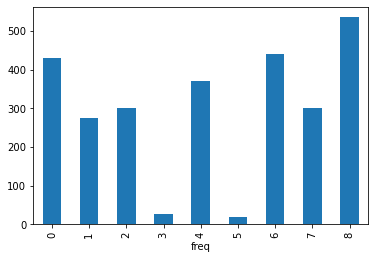

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# output the frequency 
df = pd.DataFrame({'freq': train_labels_1})
df.groupby('freq', as_index=False).size().plot(kind='bar')
plt.show()

Note in this class we are grouping category 6 to 12 as group No.6, category 13 as group No.7, and category 14 as group No.8. According to the graph of frequency distribution for the training data, we see that we have a probelm of imbalance of training set, especially for group 3 and group 5. So we decide to manually generate some "fake" training data for group 3 and group 5 through the data augementation techniques below 

## Data Augementation 
The main idea of data augementation is to generate "fake" new training data for the group that has way too few training images for the models to be sucessufl later. So we first generate new data for group 3 and then for group 5. 

In [7]:
from numpy import array

# generate a list of indicis of a certain group in the label list
def find_indices_for_group_x(listOfLabel, group_no):
    res = []
    i = 0 
    for i in range(0,len(listOfLabel)):
        if (listOfLabel[i] == group_no):
            res.append(i)
    return res

# indices for group 3 in the label list and training set 
group_3_indices = find_indices_for_group_x(train_labels_1, 3)

# subset of all the group 3 from the training set 
group_3_images = array(train_images_1)[group_3_indices]

# check the number of group 3 already available at training data 
print(len(group_3_indices))
print(len(group_3_images))


26
26


In [8]:
# indices for group 5 in the label list and training set 
group_5_indices = find_indices_for_group_x(train_labels_1, 5)

# subset of all the group 5 from the training set 
group_5_images = array(train_images_1)[group_5_indices]

# check the number of group 3 already available at training data 
print(len(group_5_indices))
print(len(group_5_images))

18
18


In [9]:
# Data augementation 
# generate more category FIVE

def rotate_a_bunch(a_list_of_image):
    res = []
    for i in range(0, len(a_list_of_image)):
        rotate_once1 = np.rot90(a_list_of_image[i], k=1, axes=(0, 1))
        a = rotate_once1[::-1]
        rotate_twice1 = np.rot90(rotate_once1, k=1, axes=(0, 1))
        b = rotate_twice1[::-1]
        rotate_third1 = np.rot90(rotate_twice1, k=1, axes=(0, 1))
        c = rotate_third1[::-1]
        rotate_once2 = np.rot90(a_list_of_image[i], k=1, axes=(1, 0))
        d= rotate_once2[::-1]
        rotate_twice2 = np.rot90(rotate_once2, k=1, axes=(1, 0))
        e = rotate_twice2[::-1]
        rotate_third2 = np.rot90(rotate_twice2, k=1, axes=(1, 0))
        f = rotate_third2[::-1]
        
        new_gen = [rotate_once1,rotate_once2, rotate_twice1,rotate_twice2,rotate_third1, rotate_third2 ]
        new_gen2 = [a,b,c,d,e,f]
        res= new_gen + res + new_gen2
    return np.array(res) 

# generate new group 3 images 
generated_3_images = rotate_a_bunch(group_3_images)

# generate new group 3 labels 
generated_3_labels = [3] * len(generated_3_images)

In [10]:
# generate new group 5 images 
generated_5_images = rotate_a_bunch(group_5_images)

# generate new group 5 labels 
generated_5_labels = [5] * len(generated_5_images)

Now we concatenate all the training images together with the new image data generated with the order preserved. Note testing data is not involved in any of the data augementation process. Because we want to ganurentee that all the testing data represents all the real image data. 

In [11]:
# create the new training data set (note test data set is already seperated out before hand) 

train_images_1_new = np.concatenate((train_images_1 , generated_3_images, generated_5_images)) 
train_labels_1_new = np.concatenate((train_labels_1 , generated_3_labels, generated_5_labels)) 

So now we can take a look at the distribution of the new training data set: 

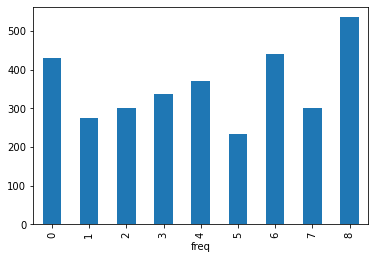

In [13]:
# output the new frequency 
df = pd.DataFrame({'freq': train_labels_1_new})
df.groupby('freq', as_index=False).size().plot(kind='bar')
plt.show()

So the imbalance of the training sample seems to be eased up a little, although group 5 still has significantly fewer training size than others. 

## Splitting the training and validation set 
We will now split the new training set in to actual training set and the validation set. The validation set is used to fine tune our model along the way. 

In [14]:
train1_images , val_images, train1_labels , val_labels =  train_test_split(train_images_1_new, train_labels_1_new, test_size=0.1, random_state=1)

## Normalize the image data
We will normalize the data by dividing 255. 

In [15]:
train1_images = train1_images / 255.0 
val_images    = val_images / 255.0 
test_images_1 = np.array(test_images_1)/ 255.0

TypeError: unsupported operand type(s) for /: 'list' and 'float'

And we can take a summary of the size of training, validation, and testing data. We can move further for our training process. 

In [21]:
print("#Training data: {}\n #Validation data: {}\n #Testing data: {}\n#Class: {}".format(len(train1_images), len(val_images), len(test_images_1), len(set(train1_labels))))

#Training data: 2901
 #Validation data: 323
 #Testing data: 675
#Class: 9


# Implementation 

We will start building our Convolutional Neurel Network model and more specifically an AlexNet 

In [22]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

I have referred to the following note when writing the architexture of Alex Net: http://datahacker.rs/tf-alexnet/

In [23]:
num_classes = len(set(train1_labels))

# AlexNet model
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))
        #drop out at 0.05 achieve 71% accuracy 
        #drop out at 0.08 achieve 81% accuracy
        #drop out at 0.1 achieve 84% accuracy in prediction
        #drop out at 0.15 achieve 80%  accuracy 
        #drop out at 0.2 achieve 80% accuracy in prediction
        #drop out at 0.3 achieve 80% accuracy in prediction 
        #drop out at 0.4 achieve 79% accuracy in prediction 
        #drop out at 0.5 achieve 73% accuracy in prediction 
        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.1))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.1))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dropout(0.1))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.0001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

Now we will compile our model and take a look at the summary of the layers information 

In [24]:
model = AlexNet((200, 200, 6), num_classes)
model.summary()


Model: "alex_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 96)        69792     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 256)       884

In [25]:
# start training
history = model.fit(train1_images, train1_labels, epochs=10, 
                    validation_data=(val_images, val_labels))

Epoch 1/10
91/91 [==============================] - 270s 3s/step - loss: 2.0303 - accuracy: 0.2727 - val_loss: 1.7675 - val_accuracy: 0.4180
Epoch 2/10
91/91 [==============================] - 253s 3s/step - loss: 1.5016 - accuracy: 0.4767 - val_loss: 1.3903 - val_accuracy: 0.4985
Epoch 3/10
91/91 [==============================] - 254s 3s/step - loss: 1.1674 - accuracy: 0.6005 - val_loss: 1.1384 - val_accuracy: 0.5789
Epoch 4/10
91/91 [==============================] - 263s 3s/step - loss: 0.9644 - accuracy: 0.6680 - val_loss: 1.0185 - val_accuracy: 0.6440
Epoch 5/10
91/91 [==============================] - 249s 3s/step - loss: 0.8215 - accuracy: 0.7215 - val_loss: 1.0926 - val_accuracy: 0.6347
Epoch 6/10
91/91 [==============================] - 256s 3s/step - loss: 0.6970 - accuracy: 0.7549 - val_loss: 0.8308 - val_accuracy: 0.7276
Epoch 7/10
91/91 [==============================] - 274s 3s/step - loss: 0.5757 - accuracy: 0.7956 - val_loss: 0.8513 - val_accuracy: 0.7183
Epoch 8/10
91

# Results and Analysis

We can graph the performance of the training over the 10 epochs below:

11/11 - 5s - loss: 0.8665 - accuracy: 0.7307


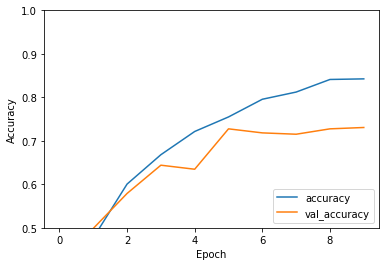

In [34]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_images,  val_labels, verbose=2)

We see that the accuracy and validated accuracy doesn't seem to converge. 

Then we can make the predictionss with the following: 

In [27]:
# make prediction
predicted_label = model.predict_classes(test_images_1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Then we can draw the confusion matrix. The following section of code is origianlly from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [52]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
   
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

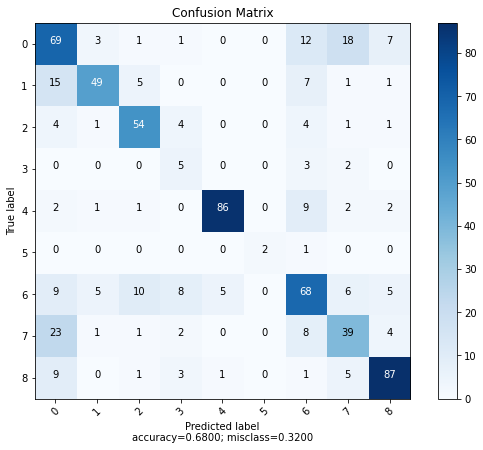

In [53]:
from sklearn.metrics import classification_report, confusion_matrix

plot_confusion_matrix(cm           = confusion_matrix(test_labels_1, predicted_label), 
                      normalize    = False,
                      target_names = [0,1,2,3,4,5,6,7,8],
                      title        = "Confusion Matrix")

In [44]:
print(classification_report(test_labels_1, predicted_label))

              precision    recall  f1-score   support

           0       0.53      0.62      0.57       111
           1       0.82      0.63      0.71        78
           2       0.74      0.78      0.76        69
           3       0.22      0.50      0.30        10
           4       0.93      0.83      0.88       103
           5       1.00      0.67      0.80         3
           6       0.60      0.59      0.59       116
           7       0.53      0.50      0.51        78
           8       0.81      0.81      0.81       107

    accuracy                           0.68       675
   macro avg       0.69      0.66      0.66       675
weighted avg       0.70      0.68      0.69       675



We see the accuracy based on the testing images is around 68% which is a little lower than the estimated 70% based on the validated accuracy. 

# Task 2:

For task 2, we will only be taking the image data that is known to come from four categories of 1, 2, 5, and 13. And we will train and test among this subset of data. We will do the similar data preprocessing procedures. Like we did in the task 1 with data augementation of category 5 because it has signifcantly smaller sample size. And we will perform the normalization like before.

In [ ]:
# first select the four categories out of the original sample. 
def find_indices_four_cat(listOfLabel):
    res = []
    i = 0 
    for i in range(0,len(listOfLabel)):
        if (listOfLabel[i] == 1) or (listOfLabel[i]== 2) or (listOfLabel[i] == 5) or (listOfLabel[i] == 13): 
            res.append(i)
    return res

label_four_cat_indices = find_indices_four_cat(labels)

# select the fours category out of the sample 
labels_four_cat = array(labels)[label_four_cat_indices]
samples_four_cat = array(imgs)[label_four_cat_indices]

labels = labels_four_cat
imgs = samples_four_cat




# Conclusions 

In [ ]:
print(imgs[1230].shape)

In [ ]:
# another way of selecting categories
from numpy import array

myIndices = []




In [ ]:
labels = labels_four_cat
imgs = samples_four_cat

print(len(imgs))



##### Padding
- https://blog.csdn.net/wuzqChom/article/details/74785643
- https://stackoverflow.com/questions/47697622/cnn-image-resizing-vs-padding-keeping-aspect-ratio-or-not/49882055#49882055
- https://stackoverflow.com/questions/43391205/add-padding-to-images-to-get-them-into-the-same-shape

##### Split data

##### Normalize data

In [ ]:

#first split, split to the training and testing (we will futher split training later because we need validation set )
train_images, test_images, train_labels, test_labels = np.array(train_images), np.array(test_images), np.array(train_labels), np.array(test_labels)
train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
train_images.shape
print(len(test_labels))
# note all the test labels are real images at this point. We are only going to generate fake data for the training set

In [ ]:
# subset all the 5s 
def find_indices_5(listOfLabel):
    res = []
    i = 0 
    for i in range(0,len(listOfLabel)):
        if (listOfLabel[i] == 5): 
            res.append(i)
    return res

label_five = find_indices_5(train_labels)
print(len(label_five))

train_is_five = array(train_images)[label_five]

# the is the training data that has labelled as "5"
print(train_is_five)

##### Generate fake data

Data augementation. Because category five has only 13 samples. We decide to rotate them and flip them and etc. 

In [ ]:
# Data augementation 
# generate more category FIVE

def rotate_a_bunch(a_list_of_image):
    res = []
    for i in range(0, len(a_list_of_image)):
        rotate_once1 = np.rot90(a_list_of_image[i], k=1, axes=(0, 1))
        a = rotate_once1[::-1]
        rotate_twice1 = np.rot90(rotate_once1, k=1, axes=(0, 1))
        b = rotate_twice1[::-1]
        rotate_third1 = np.rot90(rotate_twice1, k=1, axes=(0, 1))
        c = rotate_third1[::-1]
        rotate_once2 = np.rot90(a_list_of_image[i], k=1, axes=(1, 0))
        d= rotate_once2[::-1]
        rotate_twice2 = np.rot90(rotate_once2, k=1, axes=(1, 0))
        e = rotate_twice2[::-1]
        rotate_third2 = np.rot90(rotate_twice2, k=1, axes=(1, 0))
        f = rotate_third2[::-1]
        
        new_gen = [rotate_once1,rotate_once2, rotate_twice1,rotate_twice2,rotate_third1, rotate_third2 ]
        new_gen2 = [a,b,c,d,e,f]
        res= new_gen + res + new_gen2
    return np.array(res) 

generated_5 = rotate_a_bunch(train_is_five)

print(generated_5)

generated_5_label = [5] * len(generated_5)

# create the new training data set (note test data set is already seperated out before hand)
train_images = np.concatenate((train_images , generated_5)) 
train_labels =  np.concatenate((train_labels , generated_5_label)) 

In [ ]:
print(len(train_images))
print(len(train_labels))
print(train_labels)

Further split training data to actual training data and validation data set. 

In [ ]:
train1_images , val_images, train1_labels , val_labels =  train_test_split(train_images, train_labels, test_size=0.2, random_state=1)

The number of each data set after the data augementation 

In [ ]:
print("#Training data: {}\n #Validation data: {}\n #Testing data: {}\n#Class: {}".format(len(train1_images), len(val_images), len(test_images), len(set(train_labels))))

In [ ]:
# rename 1,2,5,12 category number to 0 1 2 3 
def change_cat_number(list_1):
    for i in range(0,len(list_1)):
        if list_1[i] == 1:
            list_1[i] = 0
        elif list_1[i] == 2:
            list_1[i] = 1
        elif list_1[i] == 5:
            list_1[i] = 2
        else: 
            list_1[i] = 3
    return list_1

train1_labels = change_cat_number(train1_labels)
val_labels= change_cat_number(val_labels)
test_labels = change_cat_number(test_labels)


take a look at the frequency distribution of our four categories in the training data set 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# output the new frequency 
df = pd.DataFrame({'freq': train1_labels})
df.groupby('freq', as_index=False).size().plot(kind='bar')
plt.show()

Take a look at transformed labels. There should only by 0, 1,2 ,3. 

In [ ]:

print(val_labels)

##### Create model
- https://www.tensorflow.org/tutorials/images/classification

In [ ]:
num_classes = len(set(train_labels))

# AlexNet model
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))
        #drop out at 0.05 achieve 71% accuracy 
        #drop out at 0.08 achieve 81% accuracy
        #drop out at 0.1 achieve 84% accuracy in prediction
        #drop out at 0.15 achieve 80%  accuracy 
        #drop out at 0.2 achieve 80% accuracy in prediction
        #drop out at 0.3 achieve 80% accuracy in prediction 
        #drop out at 0.4 achieve 79% accuracy in prediction 
        #drop out at 0.5 achieve 73% accuracy in prediction 
        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.1))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.1))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dropout(0.1))
        self.add(Dense(num_classes, activation= 'softmax'))

#         self.compile(optimizer= tf.keras.optimizers.Adam(0.0001),
#                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#                     metrics=['accuracy'])


        self.compile(optimizer= sgd,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

In [ ]:
model = AlexNet((200, 200, 6), num_classes)
model.summary()

# start training
history = model.fit(train1_images, train1_labels, epochs=10, 
                    validation_data=(val_images, val_labels))


In [ ]:
# some training parameters
EPOCHS = 10
image_height = 200
image_width = 200
train_dir = "train"
valid_dir = "validation"
model_dir = "my_model.h5"


In [ ]:
# make prediction
predicted_label = model.predict_classes(test_images)

In [ ]:
print(predicted_label)

##### Reason why accuracy doesn't further increase
1. imbalance of trianing set 
2. learning rate too large 